# 12.715 - Final Project
Alex Hochroth & Serena Negroni

Jupyter notbook for making scatterplot figures and bar plots per station.

In [352]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import glob
import re
from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr

# Plotting stuffs
plt.rcParams.update(
    {
        "font.weight": "regular",  # bold fonts
        "text.usetex": True,
        "font.family": "serif",
        "font.serif": ["Times New Roman"],
        "axes.unicode_minus": False,
        "text.latex.preamble": r'\usepackage{amsmath}',
    }
)

fontsize = 13
colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#9467bd",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#17becf"   # teal
]

# Create discrete colormap
cmap9 = ListedColormap(colors, name="cmap_new")

In [353]:
path = "/Users/serenanegroni/Documents/PhDclasses/12.715_Env_Bioinfo/final_proj/"
path_plot = "/Users/serenanegroni/Documents/PhDclasses/12.715_Env_Bioinfo/final_proj/plots/"

In [354]:
# Stations
stats = pd.read_csv(path + "station_annotations.txt", sep="\t", header=None,
                 names=["sample_id", "Station"])

In [355]:
# Reads
minimap5_20 = pd.read_csv(path + '5_20_nonZero_rpkm_assigned_tax_minimap.csv')
bwa5_20 = pd.read_csv(path + '5_20_nonZero_rpkm_assigned_tax_bwa.csv')

small = pd.read_csv(path + '08_5_nonZero_rpkm_assigned_tax_bwa.csv') # 14742 rows
large = pd.read_csv(path + '20_180_nonZero_rpkm_assigned_tax_bwa.csv')

In [356]:
# Author reference reads
small_ref = pd.read_csv(path + '08_5_med_psbO_authorReference.csv')
large_ref = pd.read_csv(path + '20_180_med_psbO_authorReference.csv')

## Flow Cytometry

In [357]:
df = pd.read_csv(path + 'FlowCytometry.csv', sep='\t')

surf_df = df[(df['Layer'] == 'Surface')] # Only Med Stations
flowCyt = pd.merge(stats, surf_df, on='Station') # 63 rows

# filter only med stations 6 - 30
flowCyt = flowCyt[(flowCyt['Station'] >= 6) &  (flowCyt['Station'] <= 30)]

In [358]:
flowCyt['Station'].unique() # 16 stations total

array([20, 22, 26, 24, 18,  8, 23,  7, 30,  6, 25,  9, 16, 11, 14, 10])

In [359]:
cols = [
    'Synechococcus abundance (cell/mL)',
    'Prochlorococcus abundance (cell/mL)',
    'Picoeukaryote abundance (cell/mL)'
]

# Total abundance per sample summing abbunaces of Pro, Syn and Pico
flowCyt['Total abundance'] = flowCyt[cols].sum(axis=1) 

# Relative abundances
flowCyt['Synechococcus relative abundance'] = (
    (flowCyt['Synechococcus abundance (cell/mL)'] / flowCyt['Total abundance']) * 100
)

flowCyt['Prochlorococcus relative abundance'] = (
    (flowCyt['Prochlorococcus abundance (cell/mL)'] / flowCyt['Total abundance']) * 100
)

flowCyt['Other cyanobacteria relative abundance'] = (
    (flowCyt['Picoeukaryote abundance (cell/mL)'] / flowCyt['Total abundance']) * 100
)

In [360]:
# Biovolume
col_bio_vol = [
    'Synechococcus total biovolume (µm3)',
    'Prochlorococcus total biovolume (µm3)',
    'Picoeukatyors total biovolume (µm3)'
]

# Total abundance per sample summing abbunaces of Pro, Syn and Pico
flowCyt['Total BioVolume'] = flowCyt[col_bio_vol].sum(axis=1) 

# Relative abundances
flowCyt['Synechococcus relative biovolume'] = (
    (flowCyt['Synechococcus total biovolume (µm3)'] / flowCyt['Total BioVolume']) * 100
)

flowCyt['Prochlorococcus relative biovolume'] = (
    (flowCyt['Prochlorococcus total biovolume (µm3)'] / flowCyt['Total BioVolume']) * 100
)

flowCyt['Other cyanobacteria relative biovolume'] = (
    (flowCyt['Picoeukatyors total biovolume (µm3)'] / flowCyt['Total BioVolume']) * 100
)

In [361]:
# Keep only needed columns:
flow_filt = flowCyt[['sample_id', 'Station', 'Other cyanobacteria relative abundance', 
                     'Prochlorococcus relative abundance', 'Synechococcus relative abundance',
                     'Synechococcus relative biovolume', 'Prochlorococcus relative biovolume',
                     'Other cyanobacteria relative biovolume']]

### Our Data

In [362]:
# From small keep only Pro, Syn and Other cyanobacteria
keep = ['Prochlorococcus', 'Synechococcus', 'Other cyanobacteria']
small_cyano = small[ small['assigned_tax'].isin(keep) ] 

In [363]:
# Regroup each sample summing among samples
rpkm_grouped = (
    small_cyano
    .groupby(['Station', 'assigned_tax'])['mapped_counts']
    .sum()
    .reset_index()
)

In [364]:
# Calculate relative counts
# rpkm_grouped['total_rpkm'] = rpkm_grouped.groupby('sample_id')['RPKM_abund'].transform('sum')
# rpkm_grouped['relative_rpkm'] = (rpkm_grouped['RPKM_abund'] / rpkm_grouped['total_rpkm']) * 100

rpkm_grouped['total_counts'] = rpkm_grouped.groupby('Station')['mapped_counts'].transform('sum')
rpkm_grouped['relative_counts'] = (rpkm_grouped['mapped_counts'] / rpkm_grouped['total_counts']) * 100

In [365]:
merged = pd.merge(rpkm_grouped, flow_filt, on='Station', how='inner') # intersection of the two datasets

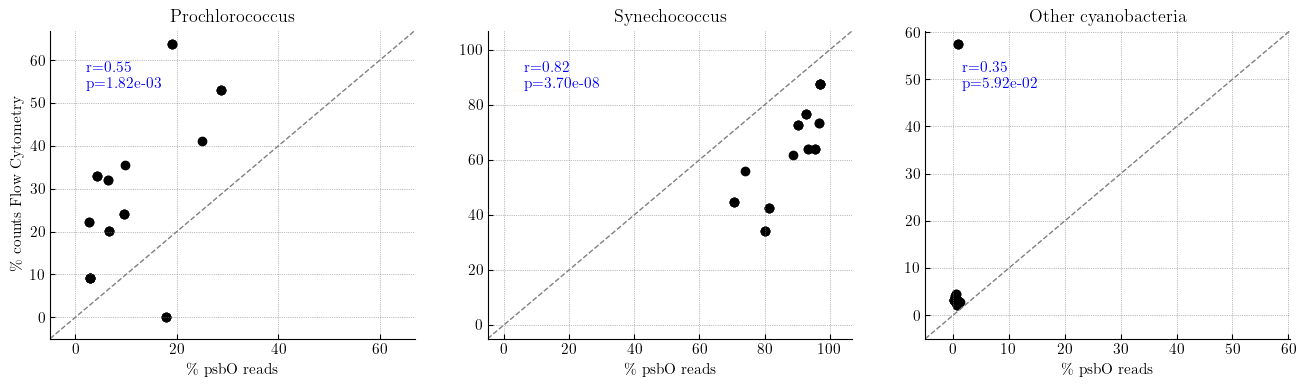

In [366]:
classe = ['Prochlorococcus', 'Synechococcus', 'Other cyanobacteria']

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
ax = axs.flatten()

for i, cc in enumerate(classe):
    phyt = merged[merged['assigned_tax'] == cc]

    # ax[i].scatter(phyt['relative_rpkm'], phyt[f'{cc} relative abundance'], c='k')
    ax[i].scatter(phyt['relative_counts'], phyt[f'{cc} relative abundance'], c='k')

    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(True)

    # 1:1 line
    # lims = [-5, max(phyt['relative_rpkm'].max() * 1.05, phyt[f'{cc} relative abundance'].max()) * 1.05]
    lims = [-5, max(phyt['relative_counts'].max() * 1.05, phyt[f'{cc} relative abundance'].max()) * 1.05]
    ax[i].plot(lims, lims, '--', color='grey', linewidth=1)
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)

    # Compute Pearson r and p-value
    # r, p = pearsonr(phyt['relative_rpkm'], phyt[f'{cc} relative abundance'])
    r, p = pearsonr(phyt['relative_counts'], phyt[f'{cc} relative abundance'])
    ax[i].text(0.1, 0.9, f'r={r:.2f}\np={p:.2e}',
               transform=ax[i].transAxes,
               fontsize=fontsize-2,
               verticalalignment='top', c='b')

    ax[i].set_xlabel(r"$\%$ psbO reads", fontsize=fontsize-2)
    ax[i].tick_params(labelsize=fontsize-2, direction='in')
    ax[i].grid(ls=':', lw=.5, c='grey')
    ax[i].set_title(classe[i], fontsize=fontsize)

    if i == 0:
        ax[i].set_ylabel(r"$\%$ counts Flow Cytometry", fontsize=fontsize-2)

fig.savefig(path_plot + 'psbO_vs_flow_counts_08-5um.png', dpi=250, bbox_inches='tight')
# fig.savefig(path_plot + 'psbO_vs_flow_rpkm_08-5um.png', dpi=250, bbox_inches='tight')

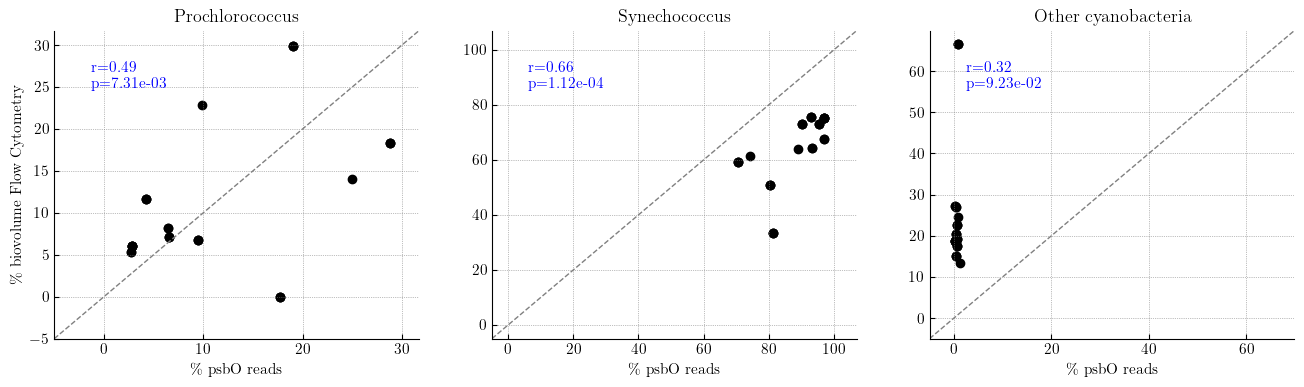

In [367]:
# Biovolume

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
ax = axs.flatten()

for i, cc in enumerate(classe):
    phyt = merged[merged['assigned_tax'] == cc]

    ax[i].scatter(phyt['relative_counts'], phyt[f'{cc} relative biovolume'], c='k')

    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(True)

    # 1:1 line
    lims = [-5, max(phyt['relative_counts'].max() * 1.05, phyt[f'{cc} relative biovolume'].max()) * 1.05]
    ax[i].plot(lims, lims, '--', color='grey', linewidth=1)
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)

    # Compute Pearson r and p-value
    r, p = pearsonr(phyt['relative_counts'], phyt[f'{cc} relative biovolume'])
    ax[i].text(0.1, 0.9, f'r={r:.2f}\np={p:.2e}',
               transform=ax[i].transAxes,
               fontsize=fontsize-2,
               verticalalignment='top', c='b')

    ax[i].set_xlabel(r"$\%$ psbO reads", fontsize=fontsize-2)
    ax[i].tick_params(labelsize=fontsize-2, direction='in')
    ax[i].grid(ls=':', lw=.5, c='grey')
    ax[i].set_title(classe[i], fontsize=fontsize)

    if i == 0:
        ax[i].set_ylabel(r"$\%$ biovolume Flow Cytometry", fontsize=fontsize-2)

fig.savefig(path_plot + 'psbO_vs_flow_biovolume_08-5um.png', dpi=250, bbox_inches='tight')

## Reference Data

### Small Size

In [368]:
# From small keep only Pro, Syn and Other cyanobacteria
keep = ['Prochlorococcus', 'Synechococcus', 'Other cyanobacteria']
small_cyano_ref = small_ref[ small_ref['lineage'].isin(keep) ] 

In [369]:
# Regroup each sample summing among samples
rpkm_grouped = (
    small_cyano_ref
    .groupby(['Station', 'lineage'])['reads_mapped']
    .sum()
    .reset_index()
)

In [370]:
# rpkm_grouped['total_rpkm'] = rpkm_grouped.groupby('sample_id')['RPKM_abund'].transform('sum')
# rpkm_grouped['relative_rpkm'] = (rpkm_grouped['RPKM_abund'] / rpkm_grouped['total_rpkm']) * 100

rpkm_grouped['total_counts'] = rpkm_grouped.groupby('Station')['reads_mapped'].transform('sum')
rpkm_grouped['relative_counts'] = (rpkm_grouped['reads_mapped'] / rpkm_grouped['total_counts']) * 100

In [371]:
merged = pd.merge(rpkm_grouped, flow_filt, on='Station', how='inner') # intersection of the two datasets
merged

,Station,lineage,reads_mapped,total_counts,relative_counts,sample_id,Other cyanobacteria relative abundance,Prochlorococcus relative abundance,Synechococcus relative abundance,Synechococcus relative biovolume,Prochlorococcus relative biovolume,Other cyanobacteria relative biovolume
0,6,Prochlorococcus,297.0,1564.0,18.989770,ERR868389,57.448972,0.000000,42.551028,33.510773,0.000000,66.489227
1,6,Prochlorococcus,297.0,1564.0,18.989770,ERR4691723,57.448972,0.000000,42.551028,33.510773,0.000000,66.489227
2,6,Prochlorococcus,297.0,1564.0,18.989770,ERR868431,57.448972,0.000000,42.551028,33.510773,0.000000,66.489227
3,6,Synechococcus,1267.0,1564.0,81.010230,ERR868389,57.448972,0.000000,42.551028,33.510773,0.000000,66.489227
4,6,Synechococcus,1267.0,1564.0,81.010230,ERR4691723,57.448972,0.000000,42.551028,33.510773,0.000000,66.489227
...,...,...,...,...,...,...,...,...,...,...,...,...
59,30,Prochlorococcus,265.0,3848.0,6.886694,ERR538178,3.254257,20.226868,76.518875,75.404181,7.069237,17.526583
60,30,Prochlorococcus,265.0,3848.0,6.886694,ERR538186,3.254257,20.226868,76.518875,75.404181,7.069237,17.526583
61,30,Synechococcus,3583.0,3848.0,93.113306,ERR538189,3.254257,20.226868,76.518875,75.404181,7.069237,17.526583
62,30,Synechococcus,3583.0,3848.0,93.113306,ERR538178,3.254257,20.226868,76.518875,75.404181,7.069237,17.526583


(32, 12)
(32, 12)


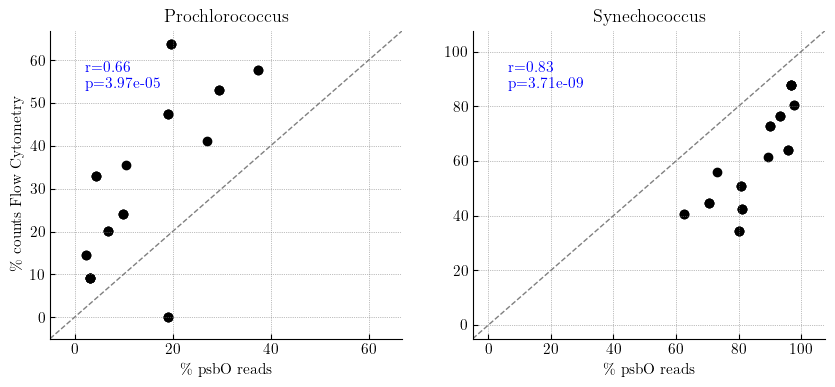

In [372]:
# Remove 'other cyanobacteria' category because its not well-defined in 
classe = ['Prochlorococcus', 'Synechococcus']

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs.flatten()

for i, cc in enumerate(classe):
    phyt = merged[merged['lineage'] == cc]
    print(phyt.shape)

    # ax[i].scatter(phyt['relative_rpkm'], phyt[f'{cc} relative abundance'], c='k')
    ax[i].scatter(phyt['relative_counts'], phyt[f'{cc} relative abundance'], c='k')

    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(True)

    # 1:1 line
    # lims = [-5, max(phyt['relative_rpkm'].max() * 1.05, phyt[f'{cc} relative abundance'].max()) * 1.05]
    lims = [-5, max(phyt['relative_counts'].max() * 1.05, phyt[f'{cc} relative abundance'].max()) * 1.05]
    ax[i].plot(lims, lims, '--', color='grey', linewidth=1)
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)

    # Compute Pearson r and p-value
    # r, p = pearsonr(phyt['relative_rpkm'], phyt[f'{cc} relative abundance'])
    r, p = pearsonr(phyt['relative_counts'], phyt[f'{cc} relative abundance'])
    ax[i].text(0.1, 0.9, f'r={r:.2f}\np={p:.2e}',
               transform=ax[i].transAxes,
               fontsize=fontsize-2,
               verticalalignment='top', c='b')

    ax[i].set_xlabel(r"$\%$ psbO reads", fontsize=fontsize-2)
    ax[i].tick_params(labelsize=fontsize-2, direction='in')
    ax[i].grid(ls=':', lw=.5, c='grey')
    ax[i].set_title(classe[i], fontsize=fontsize)

    if i == 0:
        ax[i].set_ylabel(r"$\%$ counts Flow Cytometry", fontsize=fontsize-2)

fig.savefig(path_plot + 'psbO_vs_flow_counts_08-5um_ref.png', dpi=250, bbox_inches='tight')

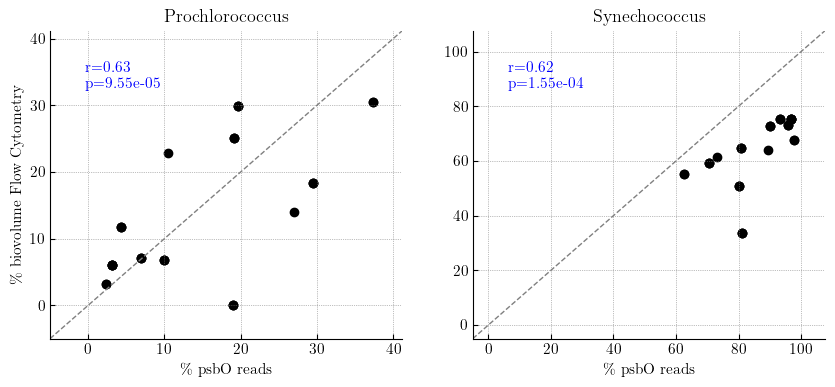

In [373]:
# Biovolume

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
ax = axs.flatten()

for i, cc in enumerate(classe):
    phyt = merged[merged['lineage'] == cc]

    ax[i].scatter(phyt['relative_counts'], phyt[f'{cc} relative biovolume'], c='k')

    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(True)

    # 1:1 line
    lims = [-5, max(phyt['relative_counts'].max() * 1.05, phyt[f'{cc} relative biovolume'].max()) * 1.05]
    ax[i].plot(lims, lims, '--', color='grey', linewidth=1)
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)

    # Compute Pearson r and p-value
    r, p = pearsonr(phyt['relative_counts'], phyt[f'{cc} relative biovolume'])
    ax[i].text(0.1, 0.9, f'r={r:.2f}\np={p:.2e}',
               transform=ax[i].transAxes,
               fontsize=fontsize-2,
               verticalalignment='top', c='b')

    ax[i].set_xlabel(r"$\%$ psbO reads", fontsize=fontsize-2)
    ax[i].tick_params(labelsize=fontsize-2, direction='in')
    ax[i].grid(ls=':', lw=.5, c='grey')
    ax[i].set_title(classe[i], fontsize=fontsize)

    if i == 0:
        ax[i].set_ylabel(r"$\%$ biovolume Flow Cytometry", fontsize=fontsize-2)

fig.savefig(path_plot + 'psbO_vs_flow_biovolume_08-5um_ref.png', dpi=250, bbox_inches='tight')

## Optical Miscoscopy

In [374]:
ds = pd.read_csv(path + 'OpticalMicroscopy_20-180_eukaryotic_phytoplankton.csv', sep='\t')
ds.rename(columns={'Bacillariophyceae' : 'Diatoms', 'Tara Oceans station' : 'Station'}, inplace=True)
med_ds = ds[(ds['Station'] >= 6) & (ds['Station'] <= 30)]

optMicr = pd.merge(stats, med_ds, on='Station')
optMicr = optMicr.rename(columns={'Other_phytoplankton' : 'Other eukaryotic phytoplankton', 'Dinophyceae' : 'Dinoflagellates',
                                  "Haptophyceae" : 'Haptophytes'})

### Our Data

In [375]:
counts_grouped = (
    large
    .groupby(['Station', 'assigned_tax'])['mapped_counts']
    .sum()
    .reset_index()
)

counts_grouped['total_counts'] = counts_grouped.groupby('Station')['mapped_counts'].transform('sum')
counts_grouped['relative_counts'] = (counts_grouped['mapped_counts'] / counts_grouped['total_counts']) * 100

In [376]:
merge2 = pd.merge(counts_grouped, optMicr, on='Station', how='inner') # length 53

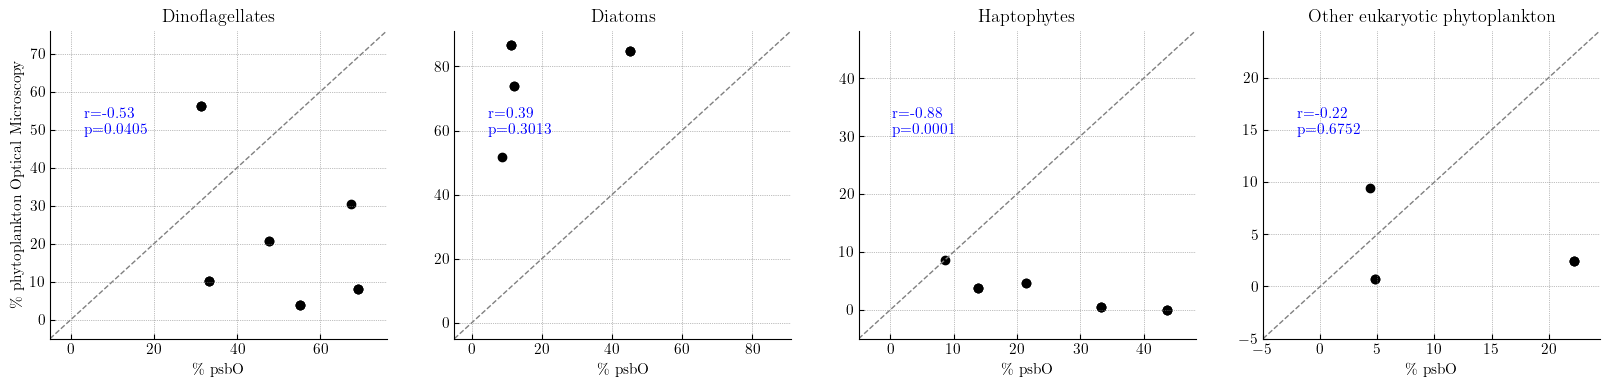

In [377]:
classe = ['Dinoflagellates', 'Diatoms', 'Haptophytes', 'Other eukaryotic phytoplankton']

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
ax = axs.flatten()

for i, cc in enumerate(classe):
    phyt = merge2[merge2['assigned_tax'] == cc]

    # ax[i].scatter(phyt['relative_rpkm'], phyt[f'{cc} relative abundance'], c='k')
    ax[i].scatter(phyt['relative_counts'], phyt[cc], c='k')

    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(True)

    # 1:1 line
    # lims = [-5, max(phyt['relative_rpkm'].max() * 1.05, phyt[f'{cc} relative abundance'].max()) * 1.05]
    lims = [-5, max(phyt['relative_counts'].max() * 1.05, phyt[cc].max()) * 1.05]
    ax[i].plot(lims, lims, '--', color='grey', linewidth=1)
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)

    # Compute Pearson r and p-value
    # r, p = pearsonr(phyt['relative_rpkm'], phyt[f'{cc} relative abundance'])
    r, p = pearsonr(phyt['relative_counts'], phyt[cc])
    ax[i].text(0.1, 0.75, f'r={r:.2f}\np={p:.4f}',
               transform=ax[i].transAxes,
               fontsize=fontsize-2,
               verticalalignment='top', c='b')

    ax[i].set_xlabel(r"$\%$ psbO", fontsize=fontsize-2)
    ax[i].tick_params(labelsize=fontsize-2, direction='in')
    ax[i].grid(ls=':', lw=.5, c='grey')
    ax[i].set_title(classe[i], fontsize=fontsize)

    if i == 0:
        ax[i].set_ylabel(r"$\%$ phytoplankton Optical Microscopy", fontsize=fontsize-2)

fig.savefig(path_plot + 'psbO_vs_optMicr_counts_20-180um.png', dpi=250, bbox_inches='tight')

### Reference Data

In [378]:
counts_grouped = (
    large_ref
    .groupby(['Station', 'lineage'])['reads_mapped']
    .sum()
    .reset_index()
)

counts_grouped['total_counts'] = counts_grouped.groupby('Station')['reads_mapped'].transform('sum')
counts_grouped['relative_counts'] = (counts_grouped['reads_mapped'] / counts_grouped['total_counts']) * 100

In [379]:
merge_ref = pd.merge(counts_grouped, optMicr, on='Station', how='inner') # length 53

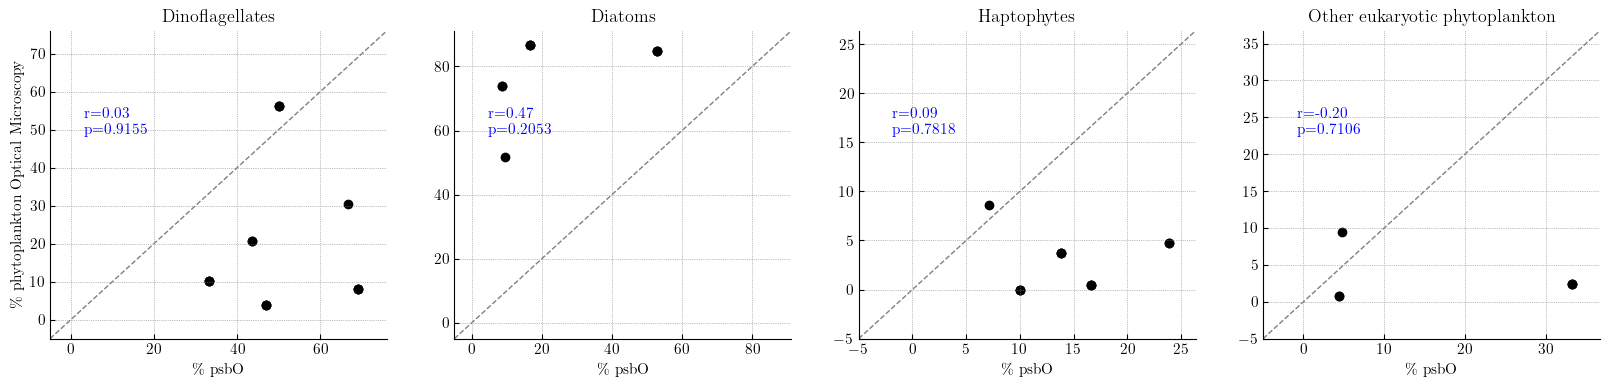

In [380]:
classe = ['Dinoflagellates', 'Diatoms', 'Haptophytes', 'Other eukaryotic phytoplankton']

fig, axs = plt.subplots(1, 4, figsize=(20, 4))
ax = axs.flatten()

for i, cc in enumerate(classe):
    phyt = merge_ref[merge_ref['lineage'] == cc]

    # ax[i].scatter(phyt['relative_rpkm'], phyt[f'{cc} relative abundance'], c='k')
    ax[i].scatter(phyt['relative_counts'], phyt[cc], c='k')

    ax[i].spines["top"].set_visible(False)
    ax[i].spines["right"].set_visible(False)
    ax[i].spines["bottom"].set_visible(True)
    ax[i].spines["left"].set_visible(True)

    # 1:1 line
    # lims = [-5, max(phyt['relative_rpkm'].max() * 1.05, phyt[f'{cc} relative abundance'].max()) * 1.05]
    lims = [-5, max(phyt['relative_counts'].max() * 1.05, phyt[cc].max()) * 1.05]
    ax[i].plot(lims, lims, '--', color='grey', linewidth=1)
    ax[i].set_xlim(lims)
    ax[i].set_ylim(lims)

    # Compute Pearson r and p-value
    # r, p = pearsonr(phyt['relative_rpkm'], phyt[f'{cc} relative abundance'])
    r, p = pearsonr(phyt['relative_counts'], phyt[cc])
    ax[i].text(0.1, 0.75, f'r={r:.2f}\np={p:.4f}',
               transform=ax[i].transAxes,
               fontsize=fontsize-2,
               verticalalignment='top', c='b')

    ax[i].set_xlabel(r"$\%$ psbO", fontsize=fontsize-2)
    ax[i].tick_params(labelsize=fontsize-2, direction='in')
    ax[i].grid(ls=':', lw=.5, c='grey')
    ax[i].set_title(classe[i], fontsize=fontsize)

    if i == 0:
        ax[i].set_ylabel(r"$\%$ phytoplankton Optical Microscopy", fontsize=fontsize-2)

fig.savefig(path_plot + 'psbO_vs_optMicr_counts_20-180um_ref.png', dpi=250, bbox_inches='tight')

## Comaparison by station

In [381]:
# from tables_refFigure.ipynb
small_ref = pd.read_csv(path + '08_5_med_psbO_authorReference.csv')
large_ref = pd.read_csv(path + '20_180_med_psbO_authorReference.csv')
mid_ref = pd.read_csv(path + '5_20_med_psbO_authorReference.csv')

In [382]:
# Plot per station counts as stscked histograms -> group per station
group_small_ref = small_ref.groupby(['Station', 'lineage'])['reads_mapped'].sum()
group_large_ref = large_ref.groupby(['Station', 'lineage'])['reads_mapped'].sum()
group_mid_ref = mid_ref.groupby(['Station', 'lineage'])['reads_mapped'].sum()

In [384]:
# Grouping our reads
grouped_small = (small.groupby(['Station', 'assigned_tax'])['mapped_counts'].sum().reset_index())

mid = pd.read_csv(path + '5_20_nonZero_rpkm_assigned_tax_bwa.csv')
grouped_mid = (mid.groupby(['Station', 'assigned_tax'])['mapped_counts'].sum().reset_index())

# Group per station our reads
group_small_our = grouped_small.groupby(['Station', 'assigned_tax'])['mapped_counts'].sum()
group_large_our = merge2.groupby(['Station', 'assigned_tax'])['mapped_counts'].sum()
group_mid_our = grouped_mid.groupby(['Station', 'assigned_tax'])['mapped_counts'].sum()

small_df = [group_small_ref, group_small_our]
large_df = [group_large_ref, group_large_our]
mid_df = [group_mid_ref, group_mid_our]

<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:22: SyntaxWarning: invalid escape sequence '\%'
/var/folders/52/p12r_zks61jf8y8l3bz6nwkh0000gn/T/ipykernel_80666/1355453072.py:22: SyntaxWarning: invalid escape sequence '\%'
  ax[i].set_ylabel("$\%$", fontsize=fontsize)


Text(0.5, 0.98, 'Mediterranean Station - Size Class: 0.8 - 5 $\\mu$m')

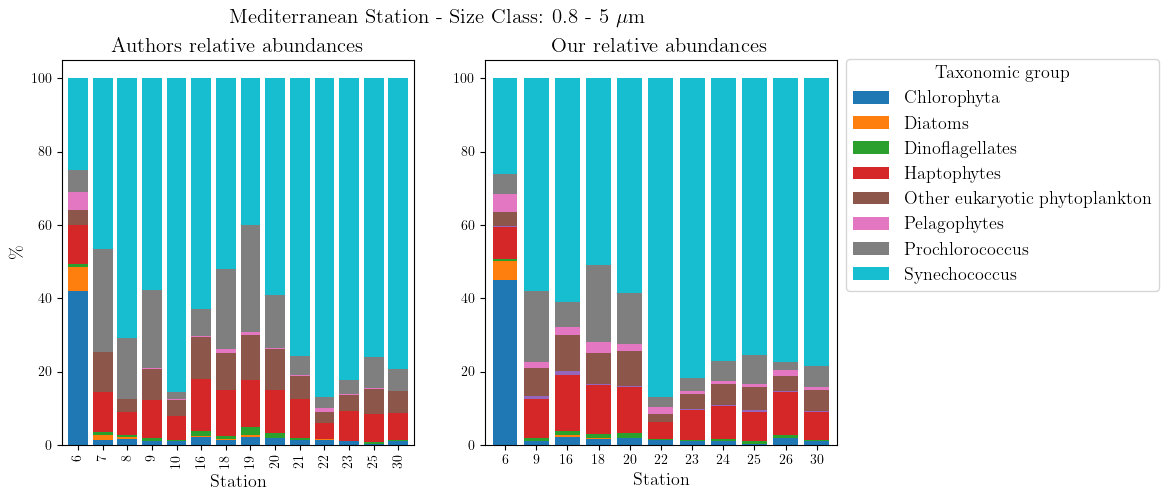

In [385]:
# SMALL SIZEs
title = ["Authors relative abundances", 'Our relative abundances']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs.flatten()

for i, df in enumerate(small_df):

    # Pivot to wide format: rows = stations, columns = taxa
    plot_df = df.unstack(fill_value=0)

    # Sort stations if needed
    plot_df = plot_df.sort_index()
    plot_df_pct = plot_df.div(plot_df.sum(axis=1), axis=0) * 100

    plot_df_pct.plot(kind='bar', stacked=True, ax=ax[i], width=0.8, colormap=cmap9, legend=False)

    ax[i].set_xlabel("Station", fontsize=fontsize)
    ax[i].set_title(title[i], fontsize=fontsize+2)

    if i == 0:
        ax[i].set_ylabel("$\%$", fontsize=fontsize)

    plt.xticks(rotation=0)

handles, labels = ax[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, title="Taxonomic group",
           bbox_to_anchor=(0.9, 0.9), loc='upper left',
           fontsize=fontsize)
leg.get_title().set_fontsize(fontsize)
fig.suptitle(r'Mediterranean Station - Size Class: 0.8 - 5 $\mu$m', fontsize=fontsize+2)



In [386]:
# Define color list to match with above class's color
colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#8c564b",  # brown
    "#e377c2",  # pink
    "xkcd:yellowish green",  # bright green
]

# Create discrete colormap
cmap11 = ListedColormap(colors, name="cmap_new")

<>:22: SyntaxWarning: invalid escape sequence '\%'
<>:22: SyntaxWarning: invalid escape sequence '\%'
/var/folders/52/p12r_zks61jf8y8l3bz6nwkh0000gn/T/ipykernel_80666/1588384879.py:22: SyntaxWarning: invalid escape sequence '\%'
  ax[i].set_ylabel("$\%$", fontsize=fontsize)


Text(0.5, 0.98, 'Mediterranean Station - Size Class: 5 - 20 $\\mu$m')

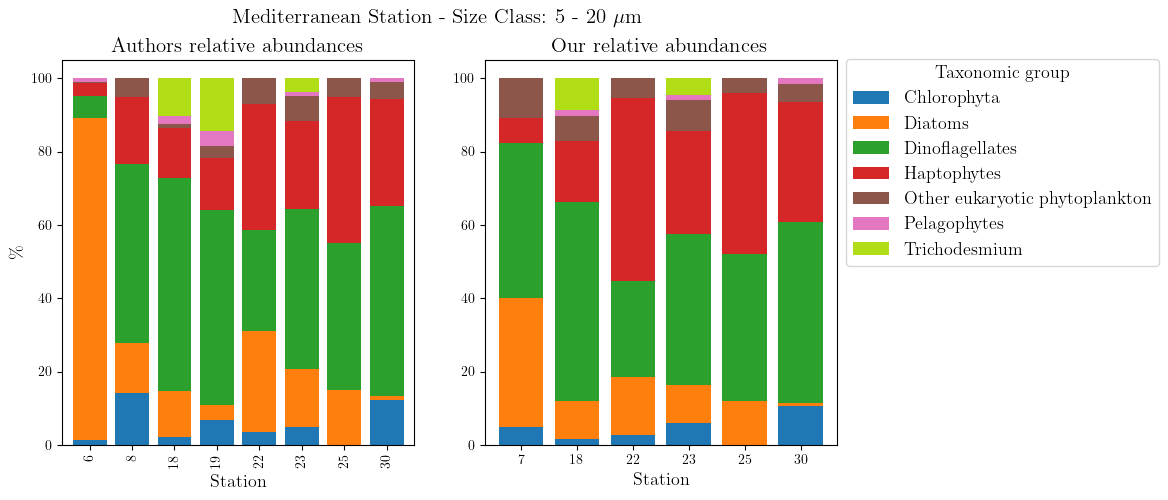

In [387]:
# MID SIZE
title = ["Authors relative abundances", 'Our relative abundances']

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs.flatten()

for i, df in enumerate(mid_df):

    # Pivot to wide format: rows = stations, columns = taxa
    plot_df = df.unstack(fill_value=0)

    # Sort stations if needed
    plot_df = plot_df.sort_index()
    plot_df_pct = plot_df.div(plot_df.sum(axis=1), axis=0) * 100

    plot_df_pct.plot(kind='bar', stacked=True, ax=ax[i], width=0.8, colormap=cmap11, legend=False)

    ax[i].set_xlabel("Station", fontsize=fontsize)
    ax[i].set_title(title[i], fontsize=fontsize+2)

    if i == 0:
        ax[i].set_ylabel("$\%$", fontsize=fontsize)

    plt.xticks(rotation=0)

handles, labels = ax[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, title="Taxonomic group",
           bbox_to_anchor=(0.9, 0.9), loc='upper left',
           fontsize=fontsize)
leg.get_title().set_fontsize(fontsize)
fig.suptitle(r'Mediterranean Station - Size Class: 5 - 20 $\mu$m', fontsize=fontsize+2)


In [388]:
# Define color list to match with above class's color
colors = [
    "#1f77b4",  # blue
    "#ff7f0e",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#8c564b",  # brown
    "#e377c2",  # pink
]

# Create discrete colormap
cmap7 = ListedColormap(colors, name="cmap_new")

<>:20: SyntaxWarning: invalid escape sequence '\%'
<>:20: SyntaxWarning: invalid escape sequence '\%'
/var/folders/52/p12r_zks61jf8y8l3bz6nwkh0000gn/T/ipykernel_80666/2474670004.py:20: SyntaxWarning: invalid escape sequence '\%'
  ax[i].set_ylabel("$\%$", fontsize=fontsize)


Text(0.5, 0.98, 'Mediterranean Station - Size Class: 20 - 180 $\\mu$m')

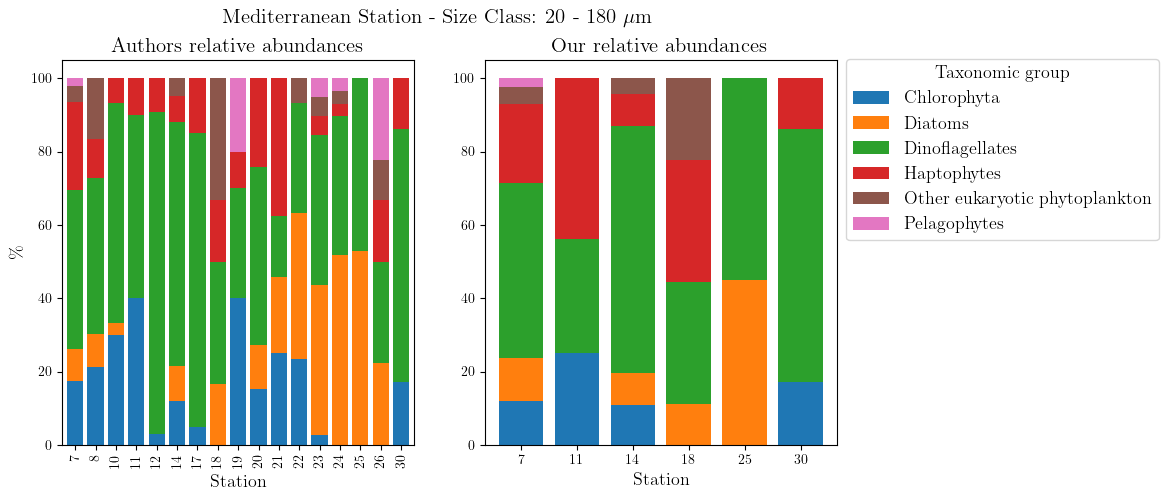

In [389]:
#LARGE SIZEs
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
ax = axs.flatten()

for i, df in enumerate(large_df):

    # Pivot to wide format: rows = stations, columns = taxa
    plot_df = df.unstack(fill_value=0)

    # Sort stations if needed
    plot_df = plot_df.sort_index()
    plot_df_pct = plot_df.div(plot_df.sum(axis=1), axis=0) * 100
    
    plot_df_pct.plot(kind='bar', stacked=True, ax=ax[i], width=0.8, legend=False, colormap=cmap7)

    ax[i].set_xlabel("Station", fontsize=fontsize)
    ax[i].set_title(title[i], fontsize=fontsize+2)

    if i == 0:
        ax[i].set_ylabel("$\%$", fontsize=fontsize)

    plt.xticks(rotation=0)

handles, labels = ax[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, title="Taxonomic group",
           bbox_to_anchor=(0.9, 0.9), loc='upper left',
           fontsize=fontsize)
leg.get_title().set_fontsize(fontsize)
fig.suptitle(r'Mediterranean Station - Size Class: 20 - 180 $\mu$m', fontsize=fontsize+2)
